### This is the simple workflow with graph

# from here phase- 1

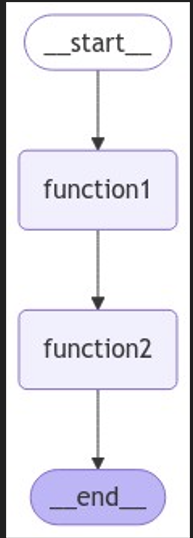

In [1]:
import os

In [2]:
def function1(input1):
    return input1 + "from first function"

def function2(input2):
    return input2 + " and savita from second function"

In [3]:
function1("sunny")

'sunnyfrom first function'

In [4]:
function2("savita")

'savita and savita from second function'

In [7]:
from langgraph.graph import Graph

In [8]:
#this is called a simple graph
#we have one more type of graph that is called stategraph
workflow1=Graph()

In [9]:
workflow1.add_node("function1", function1)

In [10]:
workflow1.add_node("function2",function2)

In [11]:
workflow1.add_edge("function1","function2")

In [12]:
workflow1.set_entry_point("function1")

In [13]:
workflow1.set_finish_point("function2")

In [14]:
app1=workflow1.compile()

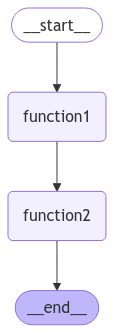

In [15]:
from IPython.display import Image, display

try:
    display(Image(app1.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [18]:
app1.invoke("hi this is saurabh ")

'hi this is saurabh from first function and savita from second function'

In [19]:
input = "hi this is sunny "

In [23]:
for i in app1.stream(input):
    print(i)

{'function1': 'hi this is sunny from first function'}
{'function2': 'hi this is sunny from first function and savita from second function'}


In [20]:
for output in app1.stream(input):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from function1
_______
hi this is sunny from first function


here is output from function2
_______
hi this is sunny from first function and savita from second function




### now explain the intermediate function

#### then come to the next workflow

# from here phase-2

### Now let's create a workflow with LLM

In [24]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="llama3-groq-70b-8192-tool-use-preview")
llm.invoke("hi").content

'Hi! How can I assist you today?'

In [95]:
from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)


In [57]:
def function1(input):
    llm=ChatGroq(model_name="llama3-groq-70b-8192-tool-use-preview")
    response=llm.invoke(input).content
    return response
    

In [27]:
def function2(input):
    upper_case=input.upper()
    return upper_case

In [28]:
from langgraph.graph import Graph
workflow2=Graph()

In [29]:
workflow2.add_node("llm",function1)

In [30]:
workflow2.add_node("upper_string",function2)

In [31]:
workflow2.add_edge("llm","upper_string")

In [32]:
workflow2.set_entry_point("llm")
workflow2.set_finish_point("upper_string")

In [33]:
app2=workflow2.compile()

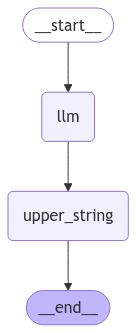

In [34]:
from IPython.display import Image, display

try:
    display(Image(app2.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [41]:
input3 = "what is the capital of india?"
for output in app2.stream(input3):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from llm
_______
The capital of India is New Delhi.


here is output from upper_string
_______
THE CAPITAL OF INDIA IS NEW DELHI.




### this is a second tool which you will create in the end of this phase
#### Now lets create our output token counter

In [59]:
def function3(input):
    print(input)
    token=input.split()
    token_number=len(token)
    token_number=f"total token number is {token_number}"
    return token_number

In [60]:
workflow3=Graph()
workflow3.add_node("llm",function1)
workflow3.add_node("token_counter",function3)
workflow3.add_edge("llm","token_counter")
workflow3.set_entry_point("llm")
workflow3.set_finish_point("token_counter")
app3=workflow3.compile()


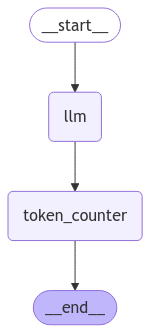

In [55]:
from IPython.display import Image, display

try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [62]:
app3.invoke("what is the capital city of India?")

The capital city of India is New Delhi.


'total token number is 8'

In [ ]:
input="ask any question"

In [41]:
for output in app3.stream(input):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from llm
_______
Hi Sunny! How can I assist you today?


here is output from token_counter
_______
8




# from here phase-3

### Question: Can we integrating a RAG Pipeline?

### Answer: yes we can!

In [143]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
loader=DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=50
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 3})

In [146]:
query = "what is meta llama3?"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

{'source': '..\\data\\llama3.txt'}
the 8B parameter version of Llama 3 as being "surprisingly capable" given it's size.[11]


In [67]:
for doc in docs:
    print(doc)

page_content='the 8B parameter version of Llama 3 as being "surprisingly capable" given it's size.[11]' metadata={'source': '..\\data\\llama3.txt'}
page_content='The latest version is Llama 3 released in April 2024.[4]' metadata={'source': '..\\data\\llama3.txt'}
page_content='and Claude in most benchmarks.[9][10] Wired describes the 8B parameter version of Llama 3 as being' metadata={'source': '..\\data\\llama3.txt'}


In [64]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

In [75]:
AgentState={}

In [76]:
AgentState["messages"]=[]

In [77]:
AgentState["messages"].append("hi, how are you?")

In [78]:
AgentState

{'messages': ['hi, how are you?']}

In [79]:
AgentState["messages"].append("hi, what you doing?")

In [80]:
AgentState

{'messages': ['hi, how are you?', 'hi, what you doing?']}

In [81]:
AgentState["messages"][-1]

'hi, what you doing?'

## what is a work of agent state? 
### the work of AgentState is just pass the message to the next node

In [85]:
def function_1(AgentState):
    
    message=AgentState["messages"]
    
    question=message[-1]
    
    complete_prompt="Your task is to provide only the brief answer based on the user query. \
        Don't include too much reasoning. Following is the user query: " + question
    
    response = llm.invoke(complete_prompt)
    
    AgentState['messages'].append(response.content) # appending LLM call response to the AgentState
    
    #print(AgentState)
    
    return AgentState

In [86]:
def function_2(AgentState):
    messages = AgentState['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

In [87]:
# Define a Langchain graph
workflow4 = Graph()
workflow4.add_node("LLM", function_1)
workflow4.add_node("RAGtool", function_2)
workflow4.add_edge('LLM', 'RAGtool')
workflow4.set_entry_point("LLM")
workflow4.set_finish_point("RAGtool")
app4 = workflow4.compile()

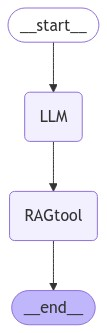

In [88]:
from IPython.display import Image, display

try:
    display(Image(app4.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [92]:
inputs = {"messages": ["Tell me about llama3 model"]}

In [93]:
inputs = {"messages": ["Tell me about llama3 model efficiency"]}

In [94]:
app4.invoke(inputs)

'The Llama 3 model, specifically the 8B parameter version, is described as "surprisingly capable" given its size. This suggests that the model is efficient in terms of its performance relative to its size. Additionally, AI\'s testing shows that Llama 3 70B beats Gemini and Claude in most benchmarks, further supporting the model\'s efficiency.'

In [126]:
inputs = {"message": ["can you give me 3 property of llama3 model"]}

In [128]:
for output in app4.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'Agent':
---
{'message': ['can you give me 3 property of llama3 model', '1. High accuracy in language tasks\n2. Can be fine-tuned for specific tasks\n3. Supports multiple languages', '1. High accuracy in language tasks\n2. Can be fine-tuned for specific tasks\n3. Supports multiple languages']}

---

Output from node 'RAGtool':
---
Based on the context provided, here are three properties of the Llama 3 model:

1. The latest version of Llama 3 was released in April 2024.
2. The 8B parameter version of Llama 3 is described as "surprisingly capable" given its size.
3. Llama 3 outperforms models like GPT-3 and Claude in most benchmarks.

---



# from here phase-4

In [64]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain.prompts import PromptTemplate

In [65]:
operator.add(10, 15)

25

In [66]:
operator.sub(10, 15)

-5

In [112]:
class AgentState(TypedDict):
    # The 'messages' field should be a sequence of strings, and we annotate it with 'operator.add'
    # This implies we might want to "add" new messages to the sequence later
    messages: Annotated[Sequence[BaseMessage], operator.add]

Messages are not appended in runtime by operator.add 

below is the proof

but append is happening inside AgentState class that lanchain team has created - abstraction

In [117]:
a = AgentState()

In [119]:
a["messages"] = "hi"

In [120]:
a["messages"] = "how are you?"

In [121]:
a["messages"]

'how are you?'

1. TypedDict:
- TypedDict is a special type that allows you to define a dictionary in Python where each key has a specific type.
It’s useful when you want to enforce type checks on the keys and values of a dictionary.

2. Annotated:
- Annotated is used to add metadata or constraints to a type.
It’s typically used for adding additional information, like constraints or descriptions, to the type.

3. Sequence[BaseMessage]:
- Sequence is a generic type from Python's typing module that represents a list-like structure (such as a list or tuple) where the order matters, and you can access elements by their position.

4. BaseMessage:
- Basemessage: This assumes you're working with the LangChain framework, and BaseMessage is part of its core messaging system. It is typically used when handling or processing messages in LangChain's workflows

5. operator.add:

- operator.add is a function from Python’s operator module that performs addition (+) on its arguments.
In this context, operator.add is being used as metadata for the Annotated type, likely suggesting that the sequence of BaseMessage objects is meant to be "added" or concatenated with another sequence at some point. It’s an indicator of how the messages field will be treated in the logic of your program.

In [68]:
from typing import TypedDict

class Person(TypedDict):
    name: str
    age: int

# Correct usage
person: Person = {
    "name": "Alice",
    "age": 30
}
# or
# person2:Person = Person(name="Bob", age=25)

In [73]:
person["name"]

'Alice'

In [74]:
person["age"]

30

### Putting It All Together:

- The line messages: Annotated[Sequence[BaseMessage], operator.add] defines a field messages that:

- Must be a sequence (like a list or tuple) of BaseMessage objects.
Has the additional annotation operator.add, which suggests that this sequence is intended to support addition (i.e., concatenation of multiple sequences of messages).

messages: Annotated[Sequence[BaseMessage], operator.add]

"messages": [BaseMessage("Hello!", "Alice"), BaseMessage("Hi!", "Bob")]

**Pydantic is a Python library for data validation and settings management using Python-type annotations. It ensures that the data you work with matches your specified data types, simplifying error handling and data parsing in Python applications.**

https://docs.pydantic.dev/latest/

1. BaseModel (from Pydantic)
- BaseModel is the base class from which all Pydantic models inherit.
- It provides built-in validation, serialization, and parsing of data.
- When you create a class that inherits from BaseModel, you are essentially defining a data model with strict type checks.

##### The BaseModel class is used for data validation and settings management in Pydantic. It's the core class that helps define data models, ensuring that attributes follow specific types and validation rules.

2. Field
The Field function is used to provide additional metadata for each field in the model. You can use it to:

- Add descriptions (as seen here).
- Set default values.
- Add validators (e.g., minimum length).
- Add constraints (like making a field optional or required).

#### Important Classes and Functions:
- BaseModel: The core class for defining data models.
- Field: Provides additional metadata and validation for model fields.
- ValidationError: Raised when validation fails.
- Constrained Types: constr, conint, conlist, etc., for restricting field values.
- Predefined Types: EmailStr, AnyUrl, HttpUrl, etc., for common validations.
- RootValidator: Used for validating the entire model or handling field interdependencies.
- Config: Model configuration options.
- parse_obj, parse_raw: Functions to parse data into models.
- validate_arguments: A decorator for function argument validation.
- Strict Types: Enforces exact type validation.

In [ ]:
#from pydantic import BaseModel,Filed,ValidationError,EmailStr,root_validator,validate_arguments,StrictInt

In [83]:
from pydantic import BaseModel

# Define a Pydantic model
class User(BaseModel):
    id: int
    name: str
    email: str

# Create an instance of the model with valid data
user = User(id=2, name="Alice", email="alice@example.com")

# Access the attributes
print(user.name)  # Output: Alice


Alice


In [84]:
# Automatic validation for types
try:
    invalid_user = User(id="abc", name="Bob", email="bob@example.com")
except Exception as e:
    print(f"Error: {e}")

Error: 1 validation error for User
id
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='abc', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/int_parsing


In [85]:
from pydantic import BaseModel , Field
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')

In [87]:
Topic: str = Field(description='Selected Topic')

In [88]:
Topic

FieldInfo(annotation=NoneType, required=True, description='Selected Topic')

##### just to check the pydantic

In [92]:
from pydantic import ValidationError

# Valid data
data = {
    "Topic": "Artificial Intelligence",
    "Reasoning": "It's a rapidly growing field with many advancements."
}

# Parsing and validating the data using the Pydantic model
try:
    topic_selection = TopicSelectionParser(**data)
    print(topic_selection.Topic)  # Output: Artificial Intelligence
    print(topic_selection.Reasoning)  # Output: It's a rapidly growing field with many advancements.
except ValidationError as e:
    print(e)

Artificial Intelligence
It's a rapidly growing field with many advancements.


In [90]:
# Invalid data (Reasoning is not a string)
invalid_data = {
    "Topic": "Artificial Intelligence",
    "Reasoning": 12345  # Invalid type, should be a string
}

# This will raise a validation error
try:
    topic_selection = TopicSelectionParser(**invalid_data)
    print(topic_selection.Topic)  # Output: Artificial Intelligence
    print(topic_selection.Reasoning)  # Output: It's a rapidly growing field with many advancements.
except ValidationError as e:
    print(e)  # This will print a detailed error message about the invalid field

1 validation error for TopicSelectionParser
Reasoning
  Input should be a valid string [type=string_type, input_value=12345, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type


- **TopicSelectionParser:** A Pydantic model that defines two fields (Topic and Reasoning), both of which are required to be strings.
- **Field:** Adds metadata, like descriptions, and can also be used for validation and constraints.
- **Pydantic’s Role:** Ensures that the data matches the expected structure and types, raising validation errors if the data is invalid.

In [153]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [7]:
parser

PydanticOutputParser(pydantic_object=<class '__main__.TopicSelectionParser'>)

In [8]:
parser.parse

<bound method PydanticOutputParser.parse of PydanticOutputParser(pydantic_object=<class '__main__.TopicSelectionParser'>)>

In [9]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [107]:
# Example prompt template for topic selection
prompt_template = PromptTemplate(
    input_variables=["user_input"],
    template="Based on the input: {user_input}, please select a topic and provide reasoning."
)

# Simulate generating an output (in a real scenario, this would be from an LLM)
user_input = "Discuss advancements in AI."
output = {
    "Topic": "Advancements in AI",
    "Reasoning": "AI has significantly improved in recent years due to advances in deep learning."
}

# Parse the output using the PydanticOutputParser
try:
    # Instead of directly parsing, create an instance of TopicSelectionParser
    parsed_result = TopicSelectionParser(**output)
    # Alternatively, if you prefer to use PydanticOutputParser:
    # parsed_result = parser.parse(output)  # This will not work since output is a dict, not a string

    # Display the parsed result
    print(parsed_result)

except Exception as e:
    print(f"Error: {e}")

Topic='Advancements in AI' Reasoning='AI has significantly improved in recent years due to advances in deep learning.'


In [154]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
loader2=DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)
docs2=loader2.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=50
)
new_docs2 = text_splitter.split_documents(documents=docs2)
doc_strings2 = [doc.page_content for doc in new_docs2]

db2 = Chroma.from_documents(new_docs2, embeddings)
retriever2 = db2.as_retriever(search_kwargs={"k": 3})

query = "Tell me about Japan's Industrial Growth?"
docs = retriever2.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

{'source': '..\\data2\\japan.txt'}
Industrial revival hope for Japan
page_content='Industrial revival hope for Japan' metadata={'source': '..\\data2\\japan.txt'}
page_content='Industrial revival hope for Japan' metadata={'source': '..\\data2\\japan.txt'}
page_content='Industrial revival hope for Japan' metadata={'source': '..\\data2\\japan.txt'}


In [129]:
from pydantic import BaseModel , Field
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')

In [130]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [132]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [244]:
def function_1(state):
    message=state["messages"]
    question=message[-1]
    print(question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [Japan, Sports, Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt = PromptTemplate(template=template,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    
                                        }
                                    )
    chain =  prompt | llm | parser
    
    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.Topic]}

In [247]:
state={"messages": ["Tell me about Japan's Industrial Growth"]}

In [248]:
function_1(state)

Tell me about Japan's Industrial Growth
Topic='Japan' Reasoning="The user query specifically asks about Japan's Industrial Growth, which falls under the category of information about Japan."


{'messages': ['Japan']}

In [225]:
def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}

In [226]:
def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

In [227]:
def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'Japan' in last_message or 'Sports' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [228]:
from langgraph.graph import StateGraph,END

workflow5 = StateGraph(AgentState) ### StateGraph with AgentState

In [229]:
workflow5.add_node("agent", function_1)

In [230]:
workflow5.add_node("RAG", function_2)

In [231]:
workflow5.add_node("LLM", function_3)

In [232]:
workflow5.set_entry_point("agent")

In [233]:
workflow5.add_conditional_edges(
    "agent",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)

In [234]:
workflow5.add_edge("RAG",END)

In [235]:
workflow5.add_edge("LLM",END)

In [236]:
app5=workflow5.compile()

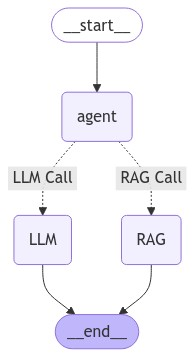

In [237]:
from IPython.display import Image, display

try:
    display(Image(app5.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [238]:
inputs = {"messages": ["Tell me about Japan's Industrial Growth"]}

In [239]:
output = app5.invoke(inputs)

Topic='Japan' Reasoning="The user query specifically asks about Japan's Industrial Growth, which is related to the category 'Japan'."
-> Router ->
Japan
-> Calling RAG ->


In [240]:
output

{'messages': ["Tell me about Japan's Industrial Growth",
  'Japan',
  'Based on the provided context, it appears that there is an "Industrial revival hope for Japan." This information is repeated across multiple documents, suggesting that there is a significant focus on the potential for industrial growth in Japan.']}

In [241]:
inputs = {"messages": ["Tell me about first prime minister of india?"]}

In [242]:
output = app5.invoke(inputs)

Topic='Not Related' Reasoning='The query is about the first prime minister of India, which is not related to Japan or sports.'
-> Router ->
Not Related
-> Calling LLM ->


In [243]:
output

{'messages': ['Tell me about first prime minister of india?',
  'Not Related',
  'The first Prime Minister of India was Jawaharlal Nehru. He served as the Prime Minister from August 15, 1947, until his death on May 27, 1964. Nehru was a key figure in the Indian independence movement and played a significant role in drafting the Constitution of India. He was known for his vision of a secular, socialist, and democratic India and his commitment to economic development and social justice.']}

# from here phase-5

In [128]:
import json
#from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langchain_core.utils.function_calling import convert_to_openai_tool

In [129]:
@tool
def multiply(first_number: int, second_number: int):
    """Multiplies two numbers together."""
    return first_number * second_number

In [130]:
tools=[convert_to_openai_tool(multiply)]

In [131]:
model_with_tools = llm.bind(tools=tools)

In [132]:
response = model_with_tools.invoke('What is 35 * 46?')

In [133]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_036z', 'function': {'arguments': '{"first_number": 35, "second_number": 46}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 209, 'total_tokens': 242, 'completion_time': 0.102965805, 'prompt_time': 0.016752075, 'queue_time': 0.016044961, 'total_time': 0.11971788}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9013b430-16a1-462d-97d2-770edf7bb39a-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 35, 'second_number': 46}, 'id': 'call_036z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 209, 'output_tokens': 33, 'total_tokens': 242})

In [134]:
tool_calls = response.additional_kwargs.get('tool_calls')

In [135]:
tool_calls

[{'id': 'call_036z',
  'function': {'arguments': '{"first_number": 35, "second_number": 46}',
   'name': 'multiply'},
  'type': 'function'}]

In [136]:
for tool_call in tool_calls:
    print('Function Name:',tool_call.get('function').get('name'))
    print('Function Arguments:',tool_call.get('function').get('arguments'))
    print(tool_call)

Function Name: multiply
Function Arguments: {"first_number": 35, "second_number": 46}
{'id': 'call_036z', 'function': {'arguments': '{"first_number": 35, "second_number": 46}', 'name': 'multiply'}, 'type': 'function'}


In [137]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [138]:
def invoke_model(state):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

In [139]:
def invoke_tool(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    print(f"here is a tool_calls {tool_calls}")
    multiply_call = None

    for tool_call in tool_calls:
        if tool_call.get("function").get("name") == "multiply":
            multiply_call = tool_call

    if multiply_call is None:
        raise Exception("No adder input found.")

    res = multiply.invoke(
        json.loads(multiply_call.get("function").get("arguments"))
    )

    return {"messages" : [res]
    }

In [140]:
from langgraph.graph import StateGraph,END
workflow6 = StateGraph(AgentState) ### StateGraph with AgentState
workflow6.add_node("agent", invoke_model)
workflow6.add_node("tool", invoke_tool)
workflow6.add_edge("tool", END)
workflow6.set_entry_point("agent")

In [141]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "multiply"
    else:
        return "end"

workflow6.add_conditional_edges("agent", router, {
    "multiply": "tool",
    "end": END,
})

In [142]:
app6 = workflow6.compile()

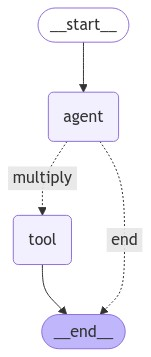

In [143]:
from IPython.display import Image, display

try:
    display(Image(app6.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [144]:
input1={"messages": ["What is 123 * 456?"]}

In [145]:

output = app6.invoke({"messages": ["What is 123 * 456?"]})

here is a tool_calls [{'id': 'call_5gwn', 'function': {'arguments': '{"first_number": 123, "second_number": 456}', 'name': 'multiply'}, 'type': 'function'}]


In [146]:
output['messages'][-1]

56088

In [147]:
output = app6.invoke({"messages": ["What is LLM?"]})

In [148]:
print(output['messages'][-1])

content='LLM can stand for several things, depending on the context:\n\n1. Large Language Model: LLM is a term used in the field of artificial intelligence to describe a type of language model that has been trained on a large amount of data and is capable of understanding and generating human-like language. These models are often used for natural language processing tasks such as text generation, language translation, and question answering.\n\n2. Master of Laws: LLM is also an abbreviation for the degree Master of Laws, which is a postgraduate law degree that typically takes one year to complete. It is designed for students who have already earned a law degree and want to specialize in a particular area of law.\n\n3. Linear Least Squares Method: LLM is also used in mathematics and statistics to refer to the Linear Least Squares Method, which is a method for finding the best fit line to a set of data points by minimizing the sum of the squares of the residuals.' additional_kwargs={} re

In [149]:
input={"messages": ["What is LLM?"]}

In [150]:
for output in app6.stream(input1):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_j9xa', 'function': {'arguments': '{"first_number": 123, "second_number": 456}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 209, 'total_tokens': 242, 'completion_time': 0.103375904, 'prompt_time': 0.016173896, 'queue_time': 0.016782064, 'total_time': 0.1195498}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f08b17bc-a0c3-4230-9792-0a34922fc330-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 123, 'second_number': 456}, 'id': 'call_j9xa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 209, 'output_tokens': 33, 'total_tokens': 242})]}


here is a tool_calls [{'id': 'call_j9xa', 'function': {'arguments': '{"first_number": 123, "second_number": 456}', 'name': 'multiply'}, 't